One of the biggest reasons athletes make so much money is that we love to watch their games. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(style="darkgrid")
plt.style.use("seaborn-pastel")

In [3]:
df = pd.read_excel("Forbes Athlete List 2012-2019.xlsx")
df.head()

,Rank,Name,Pay,Salary/Winnings,Endorsements,Sport,Year
0,#1,Lionel Messi,$127 M,$92 M,$35 M,Soccer,2019
1,#2,Cristiano Ronaldo,$109 M,$65 M,$44 M,Soccer,2019
2,#3,Neymar,$105 M,$75 M,$30 M,Soccer,2019
3,#4,Canelo Alvarez,$94 M,$92 M,$2 M,Boxing,2019
4,#5,Roger Federer,$93.4 M,$7.4 M,$86 M,Tennis,2019


In [4]:
df.shape

(795, 7)

Dataset contains `7` columns and `795` rows, let describe the data in short:

* `Rank`: Annual ranking based on salary
* `Name`: Athlete’s name
* `Salary`: Salary and Endorsement 
* `Salary / Winnings`: Athlete’s salary
* `Endorsements`: Revenue from advertising, social media, sponsors, etc.
* `Sport`: Type of athlete’s sport
* `Year`: Year of payroll

Some columns are not consistent across the dataset for example `#` before the rank value. Let’s fix this one and remove the **dollar sign** and `M`. Let’s also change `Soccer` to `Football` and `Football` to `American Football`:

In [5]:
df.Rank = df.Rank.apply(lambda x: int(x.split("#")[1]) if type(x) == np.str else x)
df.Pay = df.Pay.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Endorsements = df.Endorsements.apply(lambda x: float(x.split(" ")[0].split("$")[1]))

In [6]:
df["Salary/Winnings"].replace("-",'$nan M',inplace=True)
df["Salary/Winnings"] = df["Salary/Winnings"].apply(lambda x: float(x.split(" ")[0].split("$")[1]))

In [7]:
df.Sport.replace({"Soccer":"Football",
                  "Football":"American Football",
                 "Mixed Martial Arts":"MMA",
                 "Auto racing":"Racing",
                  "Auto Racing":"Racing",
                  "Basketbal":"Basketball",
                 },inplace=True)

df.columns = ['Rank', 'Name', 'Pay', 'Salary_Winnings', 
              'Endorsements', 'Sport', 'Year']

Now let’s see the breakdown of athletes in the data set based on their sport type:

In [11]:
sports = df.groupby("Name").first()["Sport"].value_counts()
sports.head()

American Football    101
Basketball            63
Baseball              58
Football              34
Golf                  12
Name: Sport, dtype: int64

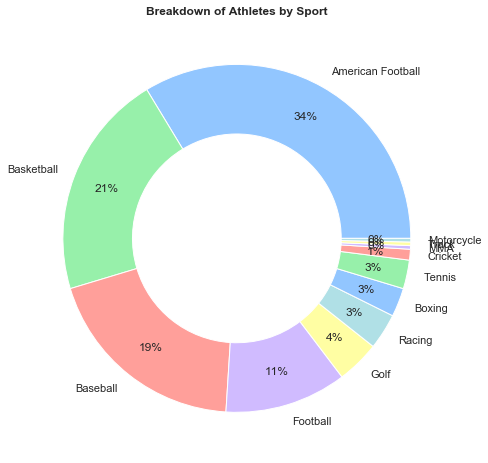

In [13]:
sports.plot(kind="pie",autopct="%.0f%%",figsize=(8,8),
            wedgeprops=dict(width=0.4),pctdistance=.8)

plt.ylabel(None)
plt.title("Breakdown of Athletes by Sport",fontweight="bold")
plt.show()

### Bar Animation for Highest-Paid Athletes 

Let’s visualize the cumulative pays of the athletes in a **running bar animation**. First, we’ll convert the `year` column to a `DateTime` object:

In [14]:
df.Year = pd.to_datetime(df.Year,format="%Y")

Next, prepare a **pivot table** where the `columns` are the **athletes** and the `index` is the **years**:

In [16]:
racing_bar_data = df.pivot_table(values="Pay",index="Year",columns="Name")
racing_bar_data.head(3)

Name,A.J. Burnett,A.J. Green,Aaron Donald,Aaron Rodgers,Adam Wainwright,Adrian Gonzalez,Adrian Peterson,Al Horford,Albert Pujols,Alex Rodriguez,...,Virat Kohli,Von Miller,Wayne Rooney,Wladimir Klitschko,Yaya Touré,Yoenis Cespedes,Zach Randolph,Zack Greinke,Zack Grienke,Zlatan Ibrahimovic
Year,,,,,,,,,,,,,,,,,,,,,
2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,21.5,NaN,17.4,33.0,...,NaN,NaN,24.3,28.0,19.1,NaN,NaN,NaN,NaN,NaN
2013-01-01,16.6,NaN,NaN,49.0,NaN,21.2,NaN,NaN,NaN,30.3,...,NaN,NaN,21.1,24.0,20.7,NaN,17.0,NaN,21.7,19.7
2014-01-01,NaN,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,23.4,28.0,21.7,NaN,18.8,NaN,NaN,40.4


The athletes mentioned below are the only ones who are consistently included in the Top 100 list for each year since `2012`. The rest of the athletes have `NaN` values. We will first interpolate the **NaNs** `linearly` and use the filling of the remaining **NaNs** with **backfilling**:

In [17]:
racing_bar_data.columns[racing_bar_data.isnull().sum() == 0]

Index(['Carmelo Anthony', 'Cristiano Ronaldo', 'Dwight Howard',
       'Justin Verlander', 'LeBron James', 'Lionel Messi', 'Phil Mickelson',
       'Rafael Nadal', 'Roger Federer', 'Tiger Woods'],
      dtype='object', name='Name')

Now convert the data to a cumulative payroll sum over several years:

In [18]:
racing_bar_filled = racing_bar_data.interpolate(method="linear").fillna(method="bfill")
racing_bar_filled = racing_bar_filled.cumsum()

Now, let’s oversample the dataset with `interpolation (linear)` for a smooth transition in the frames of the animation:

In [19]:
racing_bar_filled = racing_bar_filled.resample("1D").interpolate(method="linear")[::7]

### Creating and Saving a Bar Chart Animation

Now let’s import the Python packages needed to create and save animations, and run paths and their elements (`lines`, `bars`, `texts`, etc.). The code below will generate an animation for the 10 highest-paid athletes between `2012` and `2019`:

In [20]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

selected  = racing_bar_filled.iloc[-1,:].sort_values(ascending=False)[:20].index
data = racing_bar_filled[selected].round()

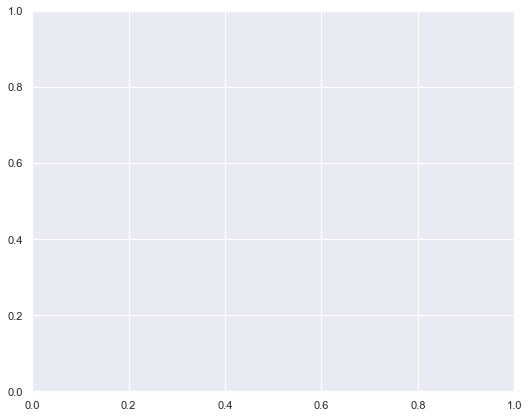

In [21]:
fig,ax = plt.subplots(figsize=(9.3,7))
fig.subplots_adjust(left=0.18)
no_of_frames = data.shape[0] #Number of frames

In [22]:
#initiate the barplot with the first rows of the dataframe
bars = sns.barplot(y=data.columns,x=data.iloc[0,:],orient="h",ax=ax)
ax.set_xlim(0,1500)
txts = [ax.text(0,i,0,va="center") for i in range(data.shape[1])]
title_txt = ax.text(650,-1,"Date: ",fontsize=12)
ax.set_xlabel("Pay (Millions USD)")
ax.set_ylabel(None)

Text(3.200000000000003, 0.5, '')

In [23]:
def animate(i):
#     print(f"i={i}/{no_of_frames}")
    #get i'th row of data 
    y = data.iloc[i,:]
    
    #update title of the barplot axis
    title_txt.set_text(f"Date: {str(data.index[i].date())}")
    
    #update elements in both plots
    for j, b, in enumerate(bars.patches):
        #update each bar's height
        b.set_width(y[j])
        
        #update text for each bar (optional)
        txts[j].set_text(f"${y[j].astype(int)}M")
        txts[j].set_x(y[j])

In [24]:
anim=FuncAnimation(fig,animate,repeat=False,frames=no_of_frames,interval=1,
                   blit=False)
anim.save('athletes.gif', writer='imagemagick', fps=120)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


In [25]:
plt.close(fig)